Testing processes (see below, in order) on new images provided by Rachel to check performance in different enviornments than what was trained on.

(1) Image Segmentation (current method: watershed)
(2) Image Measurement (Current: skimage.measure
(3) Model Classification (current: Random Forest [i] C & MC vs I & P, [ii] C vs MC

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stat
import numpy as np 
#import forestsci
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
import pickle
import glob

import sys
sys.path.append("..")
from Utility.segmentation_utils import * 

image_folder = "../Images/Additional" # Path to folder, adjust for other machines
image_list_Si = glob.glob(f'{image_folder}/Si embed/*')
image_list_Yuanwei = glob.glob(f'{image_folder}/Images to rachel (from Yuanwei)/*/*') # Might want to separate this?



Image Segmenter on L1_10nM_09 created!


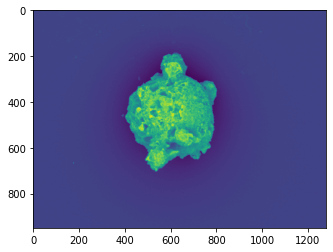

In [3]:
IS = ImageSegmenter("../Images/Additional/L1_2.5_5_10_nM/L1 10nM/L1_10nM_09.tif")
plt.imshow(IS.img2)

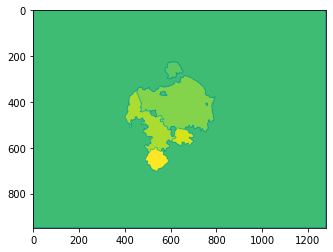

In [4]:
import matplotlib.pyplot as plt
plt.imshow(IS.markers)

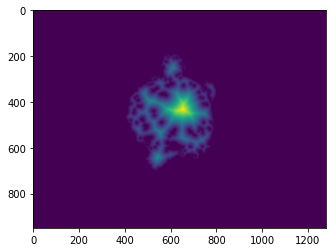

In [7]:
plt.imshow(cv2.distanceTransform(IS.thresh,cv2.DIST_L2,5))

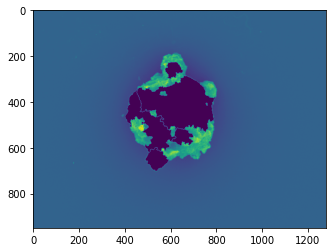

In [5]:
# Quick check so one can see what region was "forgotten" by image segmenter
img_forgotten = copy.deepcopy(IS.img2)
img_forgotten[IS.markers > 10] = 0
plt.imshow(img_forgotten)

In [5]:
# load first RF model from disk
model_name = "../Models/RF_C-MC_I-P.sav"
loaded_model = pickle.load(open(model_name, 'rb'))


In [6]:
# Prepare data
features=['area',
#        'equivalent_diameter', 
#        'orientation', 
    'major_axis_length',
    'minor_axis_length',
    'perimeter',
        'min_intensity',
        'mean_intensity',
        'max_intensity',
    'solidity',
    'major_axis_length/minor_axis_length',
    'perimeter/major_axis_length',
    'perimeter/minor_axis_length',
          'feret_diameter_max',
      'moments_hu-0',
      'moments_hu-1',
      'moments_hu-2',
#      'moments_hu-3',
#      'moments_hu-4',
#      'moments_hu-5',
#      'moments_hu-6',
#    'eccentricity'
         ]

df = IS.df
#print(np.unique(df["Filename"]))

# Modify Data (Remove illegal data OR set different runtime)

# Numerical errors (divide by 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
for feature in features:
    df.dropna(subset=[feature],inplace=True)

# Split Data (TO-DO)
X=df[features]

# Make adjustments to data
X=X # For RF, feature normalization NOT NEEDED

# NOTE (2022.08.24): What do I have to do with the classification afterwards???

#y
#ohe = OneHotEncoder(sparse=False)
#y = ohe.fit_transform(df[[label]])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [7]:
predicted_data = loaded_model.predict(X)

def assign_label(predicted_data):
    '''
    Given an array of arrays, get the max column, associate that with a name, and return the fully labeled list
    '''
    label_arr = []
    for data in predicted_data:
        index = np.argmax(data)
        if index == 0:
            label_arr.append("Crystal")
        if index == 1:
            label_arr.append("Incomplete")
    return label_arr
        
labeled_arr = assign_label(predicted_data)
IS.df['Labels'] = labeled_arr
IS.override_exists=True
IS.create_csv()
print(IS._csv_file)

../Results/values_12.csv


In [8]:
df_Crystal = IS.df[IS.df["Labels"] == "Crystal"]
df_Incomplete = IS.df[IS.df["Labels"] != "Crystal"]
print(f'Num Crystals: {len(df_Crystal)} \nNum Incomplete: {len(df_Incomplete)}')

Num Crystals: 54 
Num Incomplete: 150


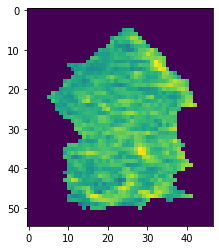

Model Thinks: Incomplete


In [ ]:

for ii in np.arange(len(IS.region_arr)):
    clear_output(wait=False)
    plt.imshow(IS.region_arr[ii])
    plt.show()
    print(f'Model Thinks: {labeled_arr[ii]}')
    input('Next (hit enter)')
